A notebook for investigating the temperamental exposure behaviour.

Hypothesis is that this is a function of the frames-per-second (fps) setting, so here we will repeat a series of exposures across a range of ~0 - 5 seconds, with different FPS settings, and we will look for patterns in where the poor performance occurs.

Trial 3 updates:
- specific exposure regions
- FPS values of 1, 2, 5, 30
- Saving of data and reloading
- Plotting of Dark Shot noise as well as mean, std signal etc.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Overview

- set exposures to trial
- set FPS to trial
- connect to cameras
- for each FPS
    - set FPS (for each camera)
    - for each camera
        - expose at each exposure
        - plot mean and std dev. vs. exposure time, logarithmic
        - record mean, std dev, exposure
- for each camera, 
    - overplot mean and std dev vs exposure, for all FPS superimposed.

Criteria:
- look for a straight line relationship between mean and exposure (after read noise has been exceeded)
- look for sections of poor performance, and look for responsible FPS setting.
- find the lowest allowed FPS setting for each exposure range.

# Setting the exposures

Minimum exposure: 60 µs, or 6E-5 seconds
Maximum exposure: for these purposes, set this to 8 seconds.

In this trial we take 5 measurements across the read noise regime,
10 measurements across the 400 - 800 ms regime (the dropout regime),
and 5 measurements across the dark signal regime, 800 ms - 8 seconds.


In [2]:
import numpy as np
min_exp = 6.01E-5
max_exp = 8.0

rn_exps = [min_exp, min_exp*2, min_exp*10, min_exp*20, min_exp*100, min_exp*200, min_exp*1000, min_exp*2000, min_exp*7000]
dropout_exps = [0.450, 0.500, 0.550, 0.600, 0.650, 0.700, 0.750, 0.800, 0.850]
dark_exps = [0.850, 1.250, 2.00, 3.50, 5.00]
exposures = np.array(rn_exps + dropout_exps + dark_exps)
exposures

array([6.010e-05, 1.202e-04, 6.010e-04, 1.202e-03, 6.010e-03, 1.202e-02,
       6.010e-02, 1.202e-01, 4.207e-01, 4.500e-01, 5.000e-01, 5.500e-01,
       6.000e-01, 6.500e-01, 7.000e-01, 7.500e-01, 8.000e-01, 8.500e-01,
       8.500e-01, 1.250e+00, 2.000e+00, 3.500e+00, 5.000e+00])

# Connecting to cameras

In [3]:
import orochi_sim_ctrl as osc

ic = osc.start_ic()
camera_config = osc.load_camera_config()
cameras = osc.connect_cameras(ic, camera_config)
osc.configure_cameras(cameras)

Device 0 (DMK 33GX249 10910288) succesfully connected.
Device 1 (DMK 33GX249 10910273) succesfully connected.
Device 2 (DMK 33GX249 10910289) succesfully connected.
Device 3 (DMK 33GX249 10910294) succesfully connected.
Device 4 (DMK 33GX249 10910291) succesfully connected.
Device 5 (DMK 33GX249 10910295) succesfully connected.
Device 7 (DMK 33GX249 23120778) succesfully connected.
Device 6 (DMK 33GX249 10910265) succesfully connected.
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
1
Video Format set to : Y16 (1920x1200)
1
Sink Format set to : "SinkFormats.Y16"
Setting Frame Rate to : 30.0 FPS
set frame rate err: 1
Frame Rate set to : 33 FPS
Brightness Value set to 0
Contrast Value set to 0
Sharpness Value set to 0
Gamma Value set to 100
Gain Value set to 4.269999980926514
Gain Auto set to 0
Exposure Value set to 0.009999999776482582
Exposure Auto set to 1
Exposure Auto Reference set to 80
Exposure Auto Max Value set to 10.0
Expo

# Setting FPS values to trial

FPS values should be trialled of 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30.

However, not all of the short FPS need to be tried. Let's trials:
1, 2, 5, 10, 16, 20 , 25, 30.

In [4]:
fpss = [30, 5, 2, 1]
# fpss = [10, 20, 30]

# Running the trials

In [5]:
import pandas as pd

def exposure_trials(camera, fpss, exposures) -> pd.DataFrame:    
    # just caputre frame at each exposure, log the exposure actually used and the exposure commanded, and the mean and std dev of the resultant image.
    fps_dat = []
    exp_dat = []
    exp_act = []
    ave_dat = []
    std_dat = []
    rsn_dat = []

    for fps in fpss:
        camera.set_frame_rate(fps)
        print(f'fps: {fps}')
        for exposure in exposures:
            print(f'exposure: {exposure}')
            camera.set_exposure(exposure)
            img = camera.image_capture(roi=True)
            img2 = camera.image_capture(roi=True)
            img_mean = np.mean(img)
            img_std = np.std(img)
            img_rs = np.sqrt(np.mean((img - img2)**2)/2)
            exposure_actual = camera.get_exposure_value()
            fps_dat.append(fps)
            exp_dat.append(exposure)
            exp_act.append(exposure_actual)
            ave_dat.append(img_mean)
            std_dat.append(img_std)
            rsn_dat.append(img_rs)
    
    results = pd.DataFrame({'fps': fps_dat, 'exposure': exp_dat, 'exposure_actual': exp_act, 'mean': ave_dat, 'std': std_dat, 'shot': rsn_dat})
    results.to_csv(f'{camera.number}_exposures_trials_13062023.csv', index=False)
    return results

In [6]:
import seaborn as sns
import orochi_sim_proc as osp

results_dict = {}
for camera in cameras:
    print('-----------------------------------')
    print(f'Camera: {camera.name}')
    results = exposure_trials(camera, fpss, exposures)
    results_dict[camera] = results
    print('-----------------------------------')

-----------------------------------
Camera: DMK 33GX249 10910288
Setting Frame Rate to : 30 FPS
set frame rate err: 1
Frame Rate set to : 33 FPS
fps: 30
exposure: 6.01e-05
Exposure Auto set to 0
Exposure Value set to 6.009999924572185e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
exposure: 0.0001202
Exposure Auto set to 0
Exposure Value set to 0.0001201999984914437
Imaging with Exposure: 0.00011999999696854502 s
+Good exposure 0.00011999999696854502 Image recieved
Imaging with Exposure: 0.00011999999696854502 s
+Good exposure 0.00011999999696854502 Image recieved
exposure: 0.000601
Exposure Auto set to 0
Exposure Value set to 0.0006009999779053032
Imaging with Exposure: 0.0006000000284984708 s
+Good exposure 0.0006000000284984708 Image recieved
Imaging with Exposure: 0.0006000000284984708 s
+Good exposure 0.0006000000284984708 Image

c:\Users\kameken\Anaconda3\envs\orochi_sim_ctrl\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kameken\Anaconda3\envs\orochi_sim_ctrl\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kameken\Anaconda3\envs\orochi_sim_ctrl\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kameken\Anaconda3\envs\orochi_sim_ctrl\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kameken\Anaconda3\envs\orochi_sim_ctrl\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwa

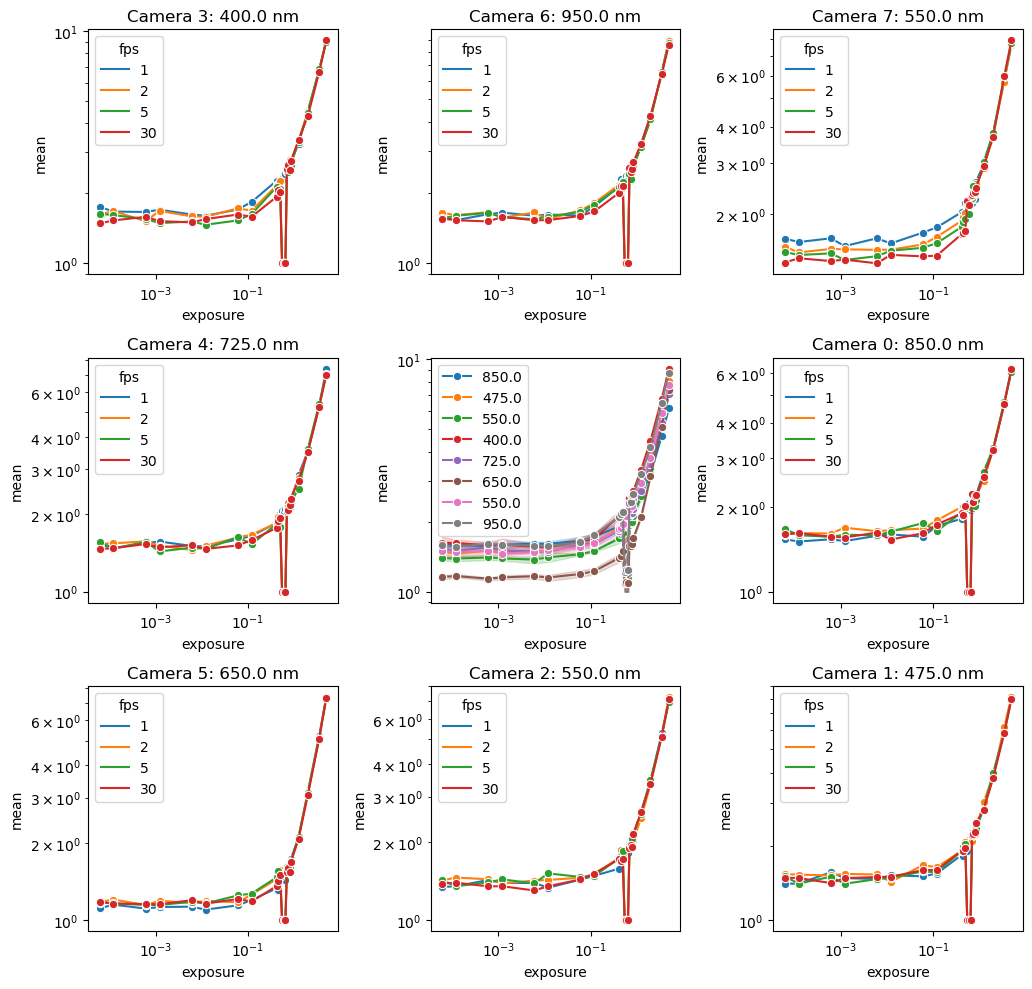

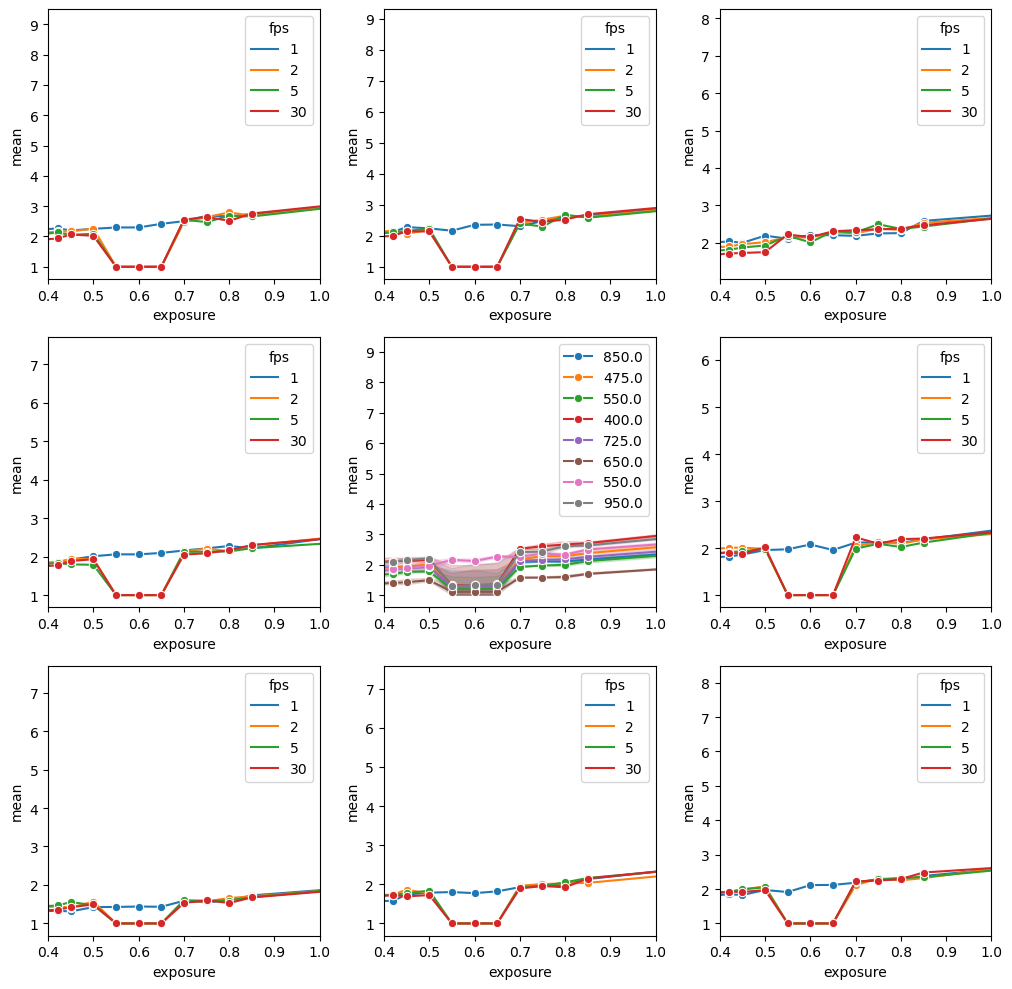

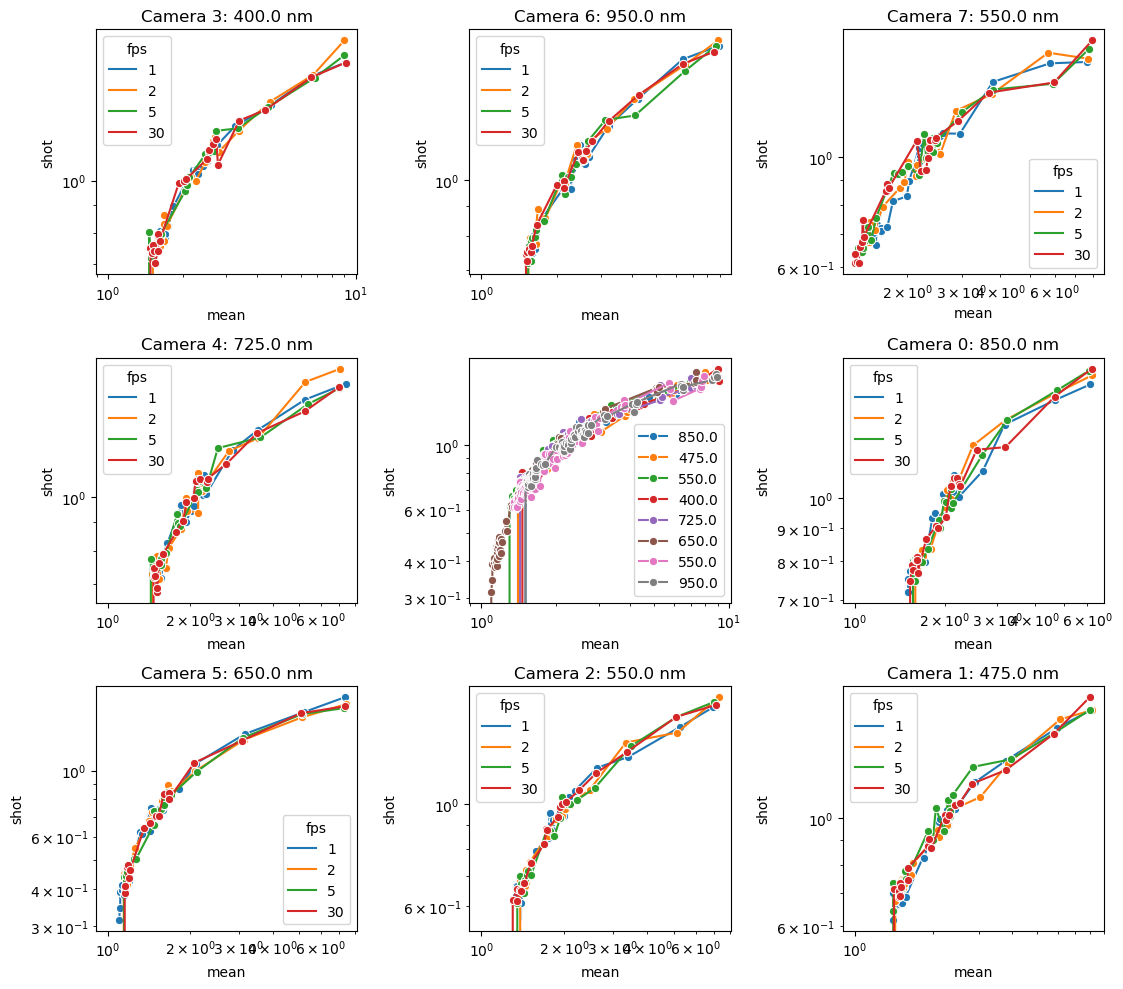

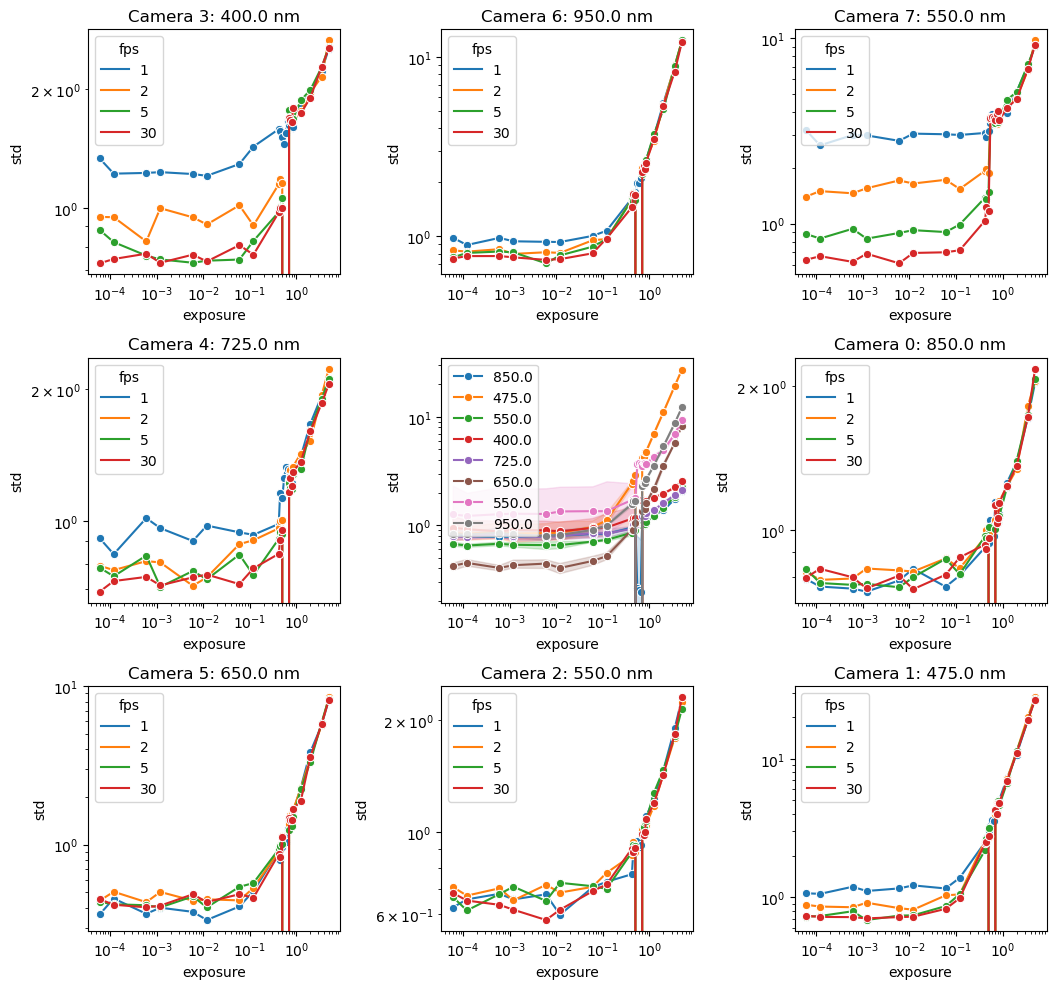

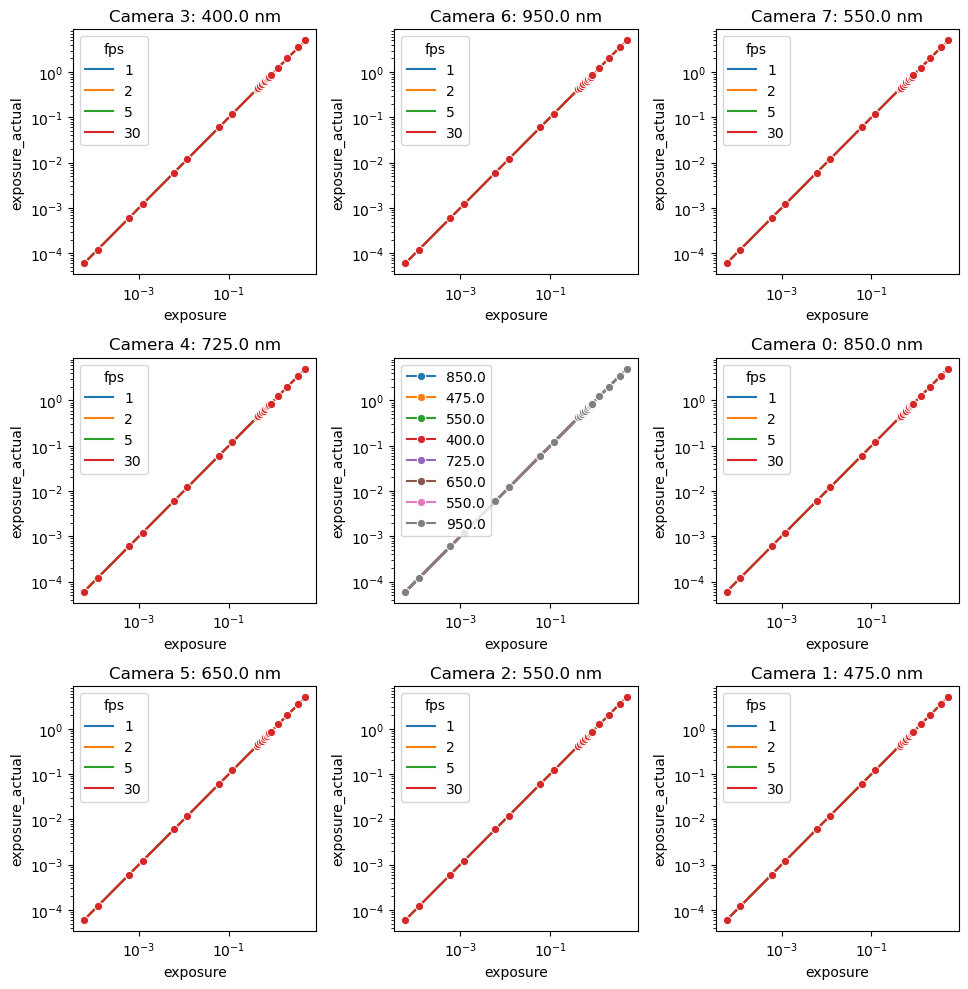

In [14]:
import seaborn as sns
import orochi_sim_proc as osp

fig_exp, ax_exp = osp.grid_plot() # init the exposure grid plot
cntr_exp = ax_exp[8] # centre plot for overlaying the exposures

fig_expl, ax_expl = osp.grid_plot() # init the exposure grid plot
cntr_expl = ax_expl[8] # centre plot for overlaying the exposures

fig_srn, ax_srn = osp.grid_plot() # init the shot+read grid plot
cntr_srn = ax_srn[8] # centre plot for overlaying the shot+read noise

fig_std, ax_std = osp.grid_plot() # init the exposure grid plot
cntr_std = ax_std[8] # centre plot for overlaying the exposures

fig_eexp, ax_eexp = osp.grid_plot() # init the exposure grid plot
cntr_eexp = ax_eexp[8] # centre plot for overlaying the exposures

for camera in cameras:
    num = camera.number
    cwl = camera.camera_props['cwl']
    chnl_str = f'Camera {num}: {cwl} nm' # create channel string
    results = results_dict[camera]

    sns.lineplot(data=results, x='exposure', y='mean', hue='fps', marker='o', dashes=False, ax=ax_exp[num], palette='tab10')
    ax_exp[num].set_xscale('log')
    ax_exp[num].set_yscale('log')
    # ax_exp[num].set_ylim(1.2,4.0)
    ax_exp[num].set_title(chnl_str)
    sns.lineplot(data=results, x='exposure', y='mean', marker='o', dashes=False, ax=cntr_exp, label=cwl)
    cntr_exp.set_xscale('log')
    cntr_exp.set_yscale('log')
    # ax_exp[num].set_ylim(1.2,4.0)


    sns.lineplot(data=results, x='exposure', y='mean', hue='fps', marker='o', dashes=False, ax=ax_expl[num], palette='tab10')
    ax_expl[num].set_xlim(0.4,1.0)
    ax_exp[num].set_title(chnl_str)
    sns.lineplot(data=results, x='exposure', y='mean', marker='o', dashes=False, ax=cntr_expl, label=cwl)
    cntr_expl.set_xlim(0.4,1.0)

    sns.lineplot(data=results, x='mean', y='shot', hue='fps', marker='o', dashes=False, ax=ax_srn[num], palette='tab10')
    ax_srn[num].set_xscale('log')
    ax_srn[num].set_yscale('log')
    ax_srn[num].set_title(chnl_str)
    sns.lineplot(data=results, x='mean', y='shot', marker='o', dashes=False, ax=cntr_srn, label=cwl)
    cntr_srn.set_xscale('log')
    cntr_srn.set_yscale('log')

    sns.lineplot(data=results, x='exposure', y='std', hue='fps', marker='o', dashes=False, ax=ax_std[num], palette='tab10')
    ax_std[num].set_xscale('log')
    ax_std[num].set_yscale('log')
    ax_std[num].set_title(chnl_str)
    sns.lineplot(data=results, x='exposure', y='std', marker='o', dashes=False, ax=cntr_std, label=cwl)
    cntr_std.set_xscale('log')
    cntr_std.set_yscale('log')

    sns.lineplot(data=results, x='exposure', y='exposure_actual', hue='fps', marker='o', dashes=False, ax=ax_eexp[num], palette='tab10')
    ax_eexp[num].set_xscale('log')
    ax_eexp[num].set_yscale('log')
    ax_eexp[num].set_title(chnl_str)
    sns.lineplot(data=results, x='exposure', y='exposure_actual', marker='o', dashes=False, ax=cntr_eexp, label=cwl)
    cntr_eexp.set_xscale('log')
    cntr_eexp.set_yscale('log')

osp.show_grid(fig_exp, ax_exp)
osp.show_grid(fig_expl, ax_expl)
osp.show_grid(fig_srn, ax_srn)
osp.show_grid(fig_std, ax_std)
osp.show_grid(fig_eexp, ax_eexp)

Observations:

Mean vs Exposure:
- again seeing dropouts in all but Camera 7, where the change in FPS results in a large change in response.
- 

